In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from helpr.physics.api import CrackEvolutionAnalysis
from helpr.physics.pipe import Pipe
from helpr.physics.crack_initiation import DefectSpecification
from helpr.physics.environment import EnvironmentSpecification
from helpr.physics.material import MaterialSpecification
from helpr.physics.stress_state import InternalAxialHoopStress
from helpr.physics.cycle_evolution import CycleEvolution
from helpr.physics.crack_growth import CrackGrowth, get_design_curve

from helpr.utilities.unit_conversion import convert_psi_to_mpa, convert_in_to_m
from helpr.utilities.plots import generate_pipe_life_assessment_plot
from helpr.utilities.postprocessing import calc_pipe_life_criteria, report_single_pipe_life_criteria_results, report_single_cycle_evolution

from probabilistic.capabilities.uncertainty_definitions import DeterministicCharacterization

## **Single Deterministic Pipeline Lifetime Evaluation**

####  **Problem Specification**

- **Geometry**

In [3]:
pipe_outer_diameter = convert_in_to_m(36)  # 36 inch outer diameter
wall_thickness = convert_in_to_m(0.406)    # 0.406 inch wall thickness

- **Material Properties**

In [4]:
yield_strength = convert_psi_to_mpa(52_000)      # material yield strength of 52_000 psi
fracture_resistance = 55                     # fracture resistance (toughness) MPa m1/2

- **Operating Conditions**

In [5]:
max_pressure = convert_psi_to_mpa(840)   # maximum pressure during oscillation MPa
min_pressure = convert_psi_to_mpa(638)   # minimum pressure during oscillation (or R = 0.75)
temperature = 293                         # K -> temperature of gas degrees C
volume_fraction_h2 = 1                      # % mole fraction H2 in natural gas blend

- **Initial Crack Dimensions**

In [6]:
flaw_depth = 25      # flaw 5% through pipe thickness
flaw_length = 0.04   # width of initial crack/flaw, m

- **Physics Model Choices**

In [7]:
stress_intensity_method = 'Anderson'  # Stress intensity factor method used

####  **Modular Analysis**

- **Create Pipe Object**

In [8]:
pipe_module = Pipe(outer_diameter=pipe_outer_diameter,
                   wall_thickness=wall_thickness)

- **Specify Pipe Material Properties**

In [9]:
material_module = MaterialSpecification(yield_strength=yield_strength,
                                        fracture_resistance=fracture_resistance)

- **Specify Defect**

In [10]:
defect_module = DefectSpecification(flaw_depth=flaw_depth,
                                    flaw_length=flaw_length)

- **Specify Pipe Gaseous Environment**

In [11]:
environment_module = EnvironmentSpecification(max_pressure=max_pressure,
                                              min_pressure=min_pressure,
                                              temperature=temperature,
                                              volume_fraction_h2=volume_fraction_h2)

- **Determine Stress Environment on Pipe**

In [12]:
stress_module = InternalAxialHoopStress(pipe=pipe_module,
                                        environment=environment_module,
                                        material=material_module,
                                        defect=defect_module,
                                        stress_intensity_method=stress_intensity_method)

- **Specify Crack Growth Model**

In [13]:
crack_growth_module = CrackGrowth(environment=environment_module,
                                  growth_model_specification={'model_name': 'code_case_2938'})

- **Evolve Cracks Over Cycles to Failure**

In [14]:
pipe_evaluation = CycleEvolution(pipe=pipe_module,
                                 stress_state=stress_module,
                                 defect=defect_module,
                                 environment=environment_module,
                                 material=material_module,
                                 crack_growth_model=crack_growth_module)
load_cycling = pipe_evaluation.calc_life_assessment()

- **Postprocess QoIs** *(life criteria)*

In [15]:
life_criteria = calc_pipe_life_criteria(cycle_results=load_cycling,
                                        pipe=pipe_module,
                                        stress_state=stress_module)

- **Plot QoI**

              Cycles to a(crit)  Cycles to 25% a(crit)  Cycles to 1/2 Nc
Total cycles        5669.414257               1.000000       2834.707129
a/t                    0.333509               0.083377          0.270803


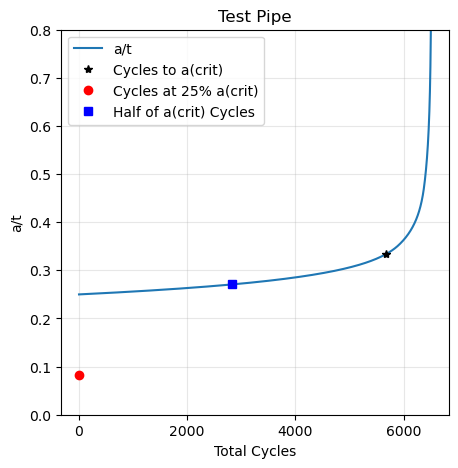

In [16]:
specific_life_criteria_result = report_single_pipe_life_criteria_results(life_criteria, pipe_index=0)
specific_load_cycling = report_single_cycle_evolution(load_cycling, pipe_index=0)
generate_pipe_life_assessment_plot(specific_load_cycling, specific_life_criteria_result, 'Test Pipe')
plt.savefig('./Figures/deterministic_crack_growth.png', format='png', dpi=300)

#### **Interact with Modular Analysis Through API**

- **Specify Problem, Initiate Crack, and Evolve Crack to Failure**

In [17]:
analysis = CrackEvolutionAnalysis(outer_diameter=DeterministicCharacterization(name='outer_diameter', value=pipe_outer_diameter),
                                  wall_thickness=DeterministicCharacterization(name='wall_thickness', value=wall_thickness),
                                  flaw_depth=DeterministicCharacterization(name='flaw_depth', value=flaw_depth),
                                  max_pressure=DeterministicCharacterization(name='max_pressure', value=max_pressure),
                                  min_pressure=DeterministicCharacterization(name='min_pressure', value=min_pressure),
                                  temperature=DeterministicCharacterization(name='temperature', value=temperature),
                                  volume_fraction_h2=DeterministicCharacterization(name='volume_fraction_h2', value=volume_fraction_h2),
                                  yield_strength=DeterministicCharacterization(name='yield_strength', value=yield_strength),
                                  fracture_resistance=DeterministicCharacterization(name='fracture_resistance', value=fracture_resistance),
                                  flaw_length=DeterministicCharacterization(name='flaw_length', value=flaw_length),
                                  stress_intensity_method=stress_intensity_method)
analysis.perform_study()

- **Postprocess and Plot QoI**

              Cycles to a(crit)  Cycles to 25% a(crit)  Cycles to 1/2 Nc
Total cycles        5669.414257               1.000000       2834.707129
a/t                    0.333509               0.083377          0.270803


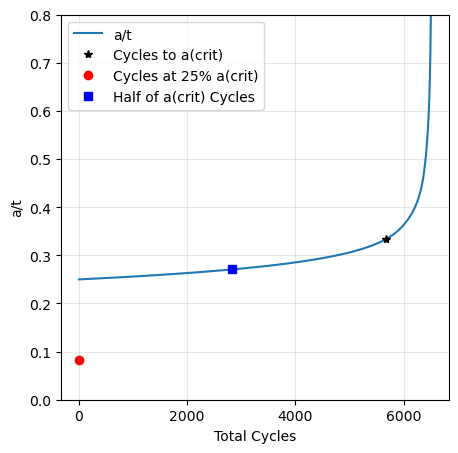

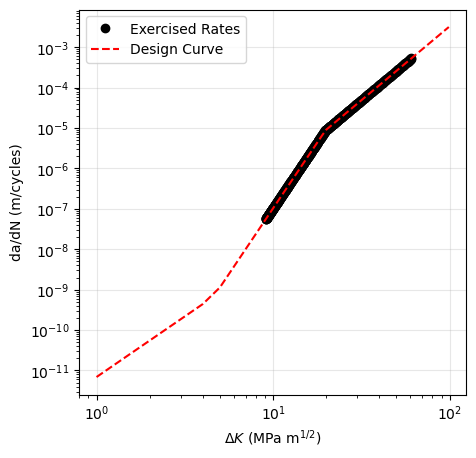

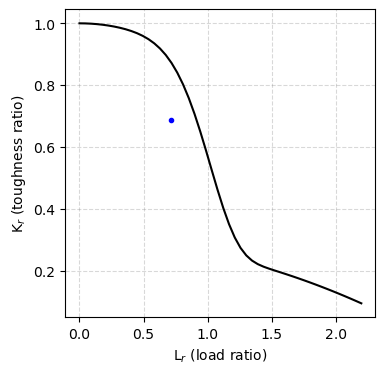

In [18]:
analysis.postprocess_single_crack_results()
analysis.get_design_curve_plot()
plt.savefig('./Figures/deterministic_crack_growth_rate.png', format='png', dpi=300)

analysis.assemble_failure_assessment_diagram()

In [19]:
analysis.save_results()

'Results/date_16_04_2024_time_11_39/'

In [20]:
analysis.gather_single_crack_cycle_evolution()

,a/t,a (m),Delta a (m),c (m),Kmax (MPa m^1/2),F,Q,Delta K (MPa m^1/2),Delta N,Total cycles,Toughness ratio,Load ratio
0,0.250000,0.002578,0.000000,0.020000,37.883303,1.962206,1.049829,9.110032,0.000000,0.000000,0.688787,0.71618
1,0.250250,0.002581,0.000003,0.020020,37.926981,1.962842,1.049829,9.120536,45.569690,45.569690,0.689581,0.71618
2,0.250500,0.002583,0.000003,0.020040,37.970700,1.963479,1.049829,9.131049,45.229724,90.799414,0.690376,0.71618
3,0.250750,0.002586,0.000003,0.020060,38.014460,1.964116,1.049829,9.141573,44.892363,135.691777,0.691172,0.71618
4,0.251001,0.002588,0.000003,0.020080,38.058481,1.964756,1.049829,9.152159,44.778700,180.470477,0.691972,0.71618
...,...,...,...,...,...,...,...,...,...,...,...,...
554,0.985078,0.010159,0.000040,0.078806,245.722047,5.555129,1.049829,59.090302,0.084100,6509.550468,4.467674,0.71618
555,0.989001,0.010199,0.000040,0.079120,247.470510,5.583550,1.049829,59.510766,0.082355,6509.632824,4.499464,0.71618
556,0.992943,0.010240,0.000041,0.079435,249.236162,5.612213,1.049829,59.935363,0.080641,6509.713465,4.531567,0.71618
557,0.996906,0.010280,0.000041,0.079752,251.019189,5.641118,1.049829,60.364138,0.078957,6509.792422,4.563985,0.71618
